In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# from dotenv import load_dotenv
# load_dotenv('.env')

# import os
# token = os.getenv("GITHUB_TOKEN")
# username = 'alessandroardenghi'
# repo = 'SemanticSegmentation'

# PART I (Data Preprocessing)

In [11]:
import random
import tensorflow as tf
import os
import os
import math
import tensorflow as tf
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def read_tiff(datapoint_path):
    img = rio.open(datapoint_path)
    img_array = img.read()
    nRows = img_array.shape[1]
    ncols = img_array.shape[2]
    Bands = img_array.shape[0]

    img_array = img_array.reshape(Bands, nRows*ncols).T
    img_array = img_array.reshape( nRows,ncols, Bands)
    
    return img_array

In [3]:
random.seed(1)

datapoints = [f'data/{element}' for element in os.listdir('data') if element.endswith('.tif')]
print(f'Example Datapoints:\n{datapoints[:3]}')

n_elements = 5000
selected_datapoints = random.sample(datapoints, n_elements)
random.shuffle(selected_datapoints)

n_folds = 5
fold_size = n_elements // n_folds
folds = [selected_datapoints[i*fold_size: (i+1)*fold_size] for i in range(n_folds)]
# Sanity Check
for i, fold in enumerate(folds):
  print(f'n_datapoints in fold {i} = {len(fold)}')

Example Datapoints:
['data/0000030240-0000043232.tif', 'data/0000016800-0000032256.tif', 'data/0000032704-0000021280.tif']
n_datapoints in fold 0 = 1000
n_datapoints in fold 1 = 1000
n_datapoints in fold 2 = 1000
n_datapoints in fold 3 = 1000
n_datapoints in fold 4 = 1000


## Image Visualization

In [149]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as colors

def plot_tiff(datapoint_path):
    img_array = read_tiff(datapoint_path)
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes[0, 0].imshow(img_array[:, :, :3]/255.0)
    axes[0, 0].set_title('RGB Image')
    axes[0, 0].axis('off')  
    
    
    axes[0, 1].imshow(img_array[:, :, 3], 'gray')
    axes[0, 1].set_title('Infrared Image')
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(img_array[:, :, 4], 'gray')
    axes[1, 0].set_title('Elevation Image')
    axes[1, 0].axis('off')
    
    word_labels = {
    0.0: 'Impervious Surface',
    1.0: 'Building',
    2.0: 'Low Vegetation',
    3.0: 'Tree',
    4.0: 'Car',
    5.0: 'Clutter/Background'
    }

    # Define boundaries for discrete colors. 
    boundaries = np.arange(-0.5, 6.5, 1)
    cmap = plt.cm.viridis  # or any other colormap of your choice
    norm = colors.BoundaryNorm(boundaries, cmap.N)

    im = axes[1, 1].imshow(img_array[:, :, 5], cmap=cmap, norm=norm)
    axes[1, 1].set_title('Masks')

    # Create a colorbar with ticks at the integer locations.
    cbar = plt.colorbar(im, ticks=np.arange(0, 6))
    cbar.ax.set_yticklabels([word_labels[i] for i in range(6)])
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

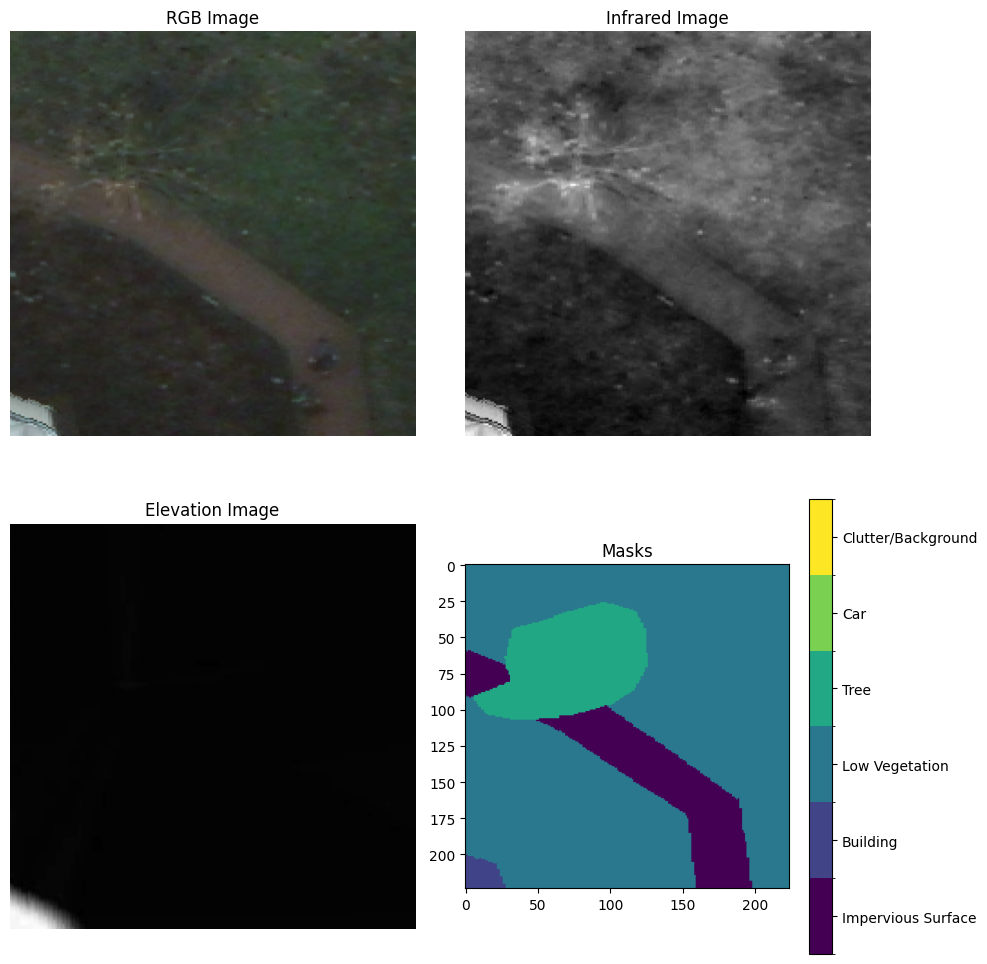

In [151]:
plot_tiff(folds[0][4])

In [4]:
TFRecord_filenames = [f'TFRecord_dir/TFRecord_fold{i}' for i in range(5)]

In [5]:
def _bytes_feature(value):        # Function taken from Tensorflow Official Documentation
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_datapoint(datapoint_filename):
    with open(datapoint_filename, 'rb') as file:
        bytes_data = file.read()

    feature = {
        'image_raw': _bytes_feature(bytes_data),
        'file_name': _bytes_feature(os.path.basename(datapoint_filename).encode('utf-8')),
    }

    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()

In [159]:
# Helper function to create a bytes_list feature.
def _bytes_feature(value):
    """Returns a bytes_list from a string/byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # Convert tensor to bytes.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_datapoint(datapoint_path):
    """
    Reads a 6-channel TIFF image and creates a serialized tf.train.Example.
    Expected channel layout:
      - Channels 0-2: RGB image
      - Channel 3: IR image
      - Channel 4: Elevation
      - Channel 5: Segmentation mask
    """
    img_array = read_tiff(datapoint_path)
    
    
    image_rgb = img_array[:, :, :3]   # (H, W, 3)
    ir = img_array[:, :, 3:4]           # (H, W, 1)
    elevation = img_array[:, :, 4:5]    # (H, W, 1)
    mask = img_array[:, :, 5:6]         # (H, W, 1)
    
    # Convert each component to bytes.
    rgb_bytes = image_rgb.tobytes()
    ir_bytes = ir.tobytes()
    elevation_bytes = elevation.tobytes()
    mask_bytes = mask.tobytes()
    file_name_bytes = os.path.basename(datapoint_path).encode('utf-8')
    
    # Create the feature dictionary.
    feature = {
        'image_rgb': _bytes_feature(rgb_bytes),
        'IR': _bytes_feature(ir_bytes),
        'elevation': _bytes_feature(elevation_bytes),
        'mask': _bytes_feature(mask_bytes),
        'file_name': _bytes_feature(file_name_bytes)
    }
    
    # Create a tf.train.Example message.
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()


In [216]:
from tqdm import tqdm
pbar = tqdm(total=5000)
for i, fold in enumerate(folds):
  tfr_name = TFRecord_filenames[i]
  with tf.io.TFRecordWriter(f"TFRecord_dir/TFRecord_fold{i}.tfrecord") as writer:
    for datapoint in fold:
        serialized_datapoint = serialize_datapoint(datapoint)
        writer.write(serialized_datapoint)
        pbar.update(1)
    
pbar.close()

100%|██████████| 5000/5000 [00:49<00:00, 101.53it/s]


# PART II (Training)

In [234]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

# Create a sequential model
model = tf.keras.Sequential()
model.add(Input(shape=(224, 224, 4)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(6, kernel_size=(3, 3), activation='softmax', padding='same'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 6)    │         1,734 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,918 (11.40 KB)

 Trainable params: 2,918 (11.40 KB)

 Non-trainable params: 0 (0.00 B)

In [235]:
def parse_datapoint(serialized_example):
    # Update feature description based on your TFRecord structure.
    feature_description = {
        'image_rgb': tf.io.FixedLenFeature([], tf.string),  
        'IR': tf.io.FixedLenFeature([], tf.string),      
        'elevation': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
        'file_name': tf.io.FixedLenFeature([], tf.string)
    }
    
    example = tf.io.parse_single_example(serialized_example, feature_description)
    
    rgb = tf.io.decode_raw(example['image_rgb'], tf.float32)
    rgb = tf.reshape(rgb, (224, 224, 3))  # assuming RGB image has 3 channels
    rgb = tf.cast(rgb, tf.float32) / 255.0
    
    ir = tf.io.decode_raw(example['IR'], tf.float32)
    ir = tf.reshape(ir, (224, 224, 1))     # assuming IR is a single channel
    
    elevation = tf.io.decode_raw(example['elevation'], tf.float32)
    elevation = tf.reshape(elevation, (224, 224, 1))  # assuming elevation is a single channel
    
    # Stack the three components along the channel dimension.
    image = tf.concat([rgb, ir, elevation], axis=-1)  # resulting shape: (224, 224, 5)
    
    # Optionally decode the mask.
    mask = tf.io.decode_raw(example['mask'], tf.float32)
    mask = tf.reshape(mask, (224, 224, 1))  # adjust dimensions as needed
    
    # Extract the label.
    filename = example['file_name']
    
    return image, mask, filename 

In [236]:
def parse_rgb_ir(serialized_datapoint):
    image, mask, _ = parse_datapoint(serialized_datapoint)
    mask = tf.squeeze(mask, axis=-1)
    mask = tf.cast(mask, tf.int32)
    mask = tf.one_hot(mask, depth=6)
    return image[:, :, :4], mask
    
    

In [232]:
file_path = "TFRecord_dir/TFRecord_fold0.tfrecord"
dataset = tf.data.TFRecordDataset(file_path)

# Retrieve one record from the dataset.
for raw_record in dataset.take(100):
    # Manually parse the record.
    image, mask = parse_rgb_ir(raw_record)
    # print("Image shape:", image.shape)
    # print("Mask shape:", mask.shape)
    if image.shape != (224, 224, 4):
        print('ERROR')
    if mask.shape != (224, 224, 6):
        print('ERROR')

In [219]:
count = 0
for _ in dataset:
    count += 1
print("Total records:", count)


Total records: 1000


In [239]:
train_filenames = [
    "TFRecord_dir/TFRecord_fold0.tfrecord",
    "TFRecord_dir/TFRecord_fold1.tfrecord",
    "TFRecord_dir/TFRecord_fold2.tfrecord"
]
eval_filenames = [
    "TFRecord_dir/TFRecord_fold3.tfrecord"]

batch_size = 32
train_dataset = (
    tf.data.TFRecordDataset(train_filenames)
    .map(parse_rgb_ir, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(buffer_size=1000)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# Create the evaluation dataset.
eval_dataset = (
    tf.data.TFRecordDataset(eval_filenames)
    .map(parse_rgb_ir, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

epochs = 20
steps_per_epoch = 3000 // 32  # Adjust if not perfectly divisible
history = model.fit(train_dataset, 
                    epochs=epochs, 
                    steps_per_epoch = steps_per_epoch,
                    validation_data=eval_dataset)

Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 49s 522ms/step - accuracy: 0.4122 - loss: 1.4197 - val_accuracy: 0.4388 - val_loss: 1.3964
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.4315 - loss: 1.5289 - val_accuracy: 0.4487 - val_loss: 1.3550
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 50s 526ms/step - accuracy: 0.4221 - loss: 1.3771 - val_accuracy: 0.4321 - val_loss: 1.3639
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.4515 - loss: 1.3678 - val_accuracy: 0.4003 - val_loss: 1.3570
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 50s 532ms/step - accuracy: 0.4074 - loss: 1.3909 - val_accuracy: 0.4474 - val_loss: 1.2923
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.4543 - loss: 1.2782 - val_accuracy: 0.4284 - val_loss: 1.3722
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 50s 532ms/step - accuracy: 0.4245 - loss: 1.3492 - val_accuracy: 0.4396 - val_loss: 1.3409
Epoch 8/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.4710 - loss: 1.3746 - val_accuracy: 0.

KeyboardInterrupt: 

In [195]:
mask.shape

TensorShape([224, 224, 1])

In [197]:
mask2 = tf.squeeze(mask, axis=-1)
mask_int = tf.cast(mask2, tf.int32)

# One-hot encode the mask so that each pixel is a vector of length 6.
one_hot_mask = tf.one_hot(mask_int, depth=6)


In [199]:
mask_int

<tf.Tensor: shape=(224, 224), dtype=int32, numpy=
array([[3, 3, 3, ..., 2, 2, 2],
       [3, 3, 3, ..., 2, 2, 2],
       [3, 3, 3, ..., 2, 2, 2],
       ...,
       [3, 3, 3, ..., 2, 2, 2],
       [3, 3, 3, ..., 2, 2, 2],
       [3, 3, 3, ..., 2, 2, 2]], dtype=int32)>

In [201]:
one_hot_mask[1, 0]

<tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 0., 0., 1., 0., 0.], dtype=float32)>